In [1]:
!pip install segmentation-models-pytorch

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# for dirname, _, filenames in os.walk('/home/jupyter/data'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
from pathlib import Path

from tqdm.notebook import tqdm

import sys, os, random, time
import numba, cv2, gc
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

from segmentation_models_pytorch.unetplusplus import UnetPlusPlus
from segmentation_models_pytorch.unet import Unet
import segmentation_models_pytorch as smp

import rasterio
from rasterio.windows import Window

import albumentations as A

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def set_seeds(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seeds()

### Setup training variables

In [4]:
DATA_PATH = Path('/home/jupyter/data/')
assert DATA_PATH.exists()

In [5]:
def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    splits = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (splits[0:][::2], splits[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype='uint8')
    for lo, hi in zip(starts, ends):
        img[lo: hi] = 1
    return img.reshape(shape, order='F') # Fortran order reshaping

In [6]:
@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(1)
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if len(points) % 2 == 0:
                points.append(i+1)
            else:
                points.append(i+1 - points[-1])
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

In [7]:
# Check run length encoding starting with 0
assert rle_numba([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [2, 2, 5, 1, 7, 4, 12, 1]
# Check run length encoding starting with 0
assert rle_numba([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [1, 3, 5, 1, 7, 4, 12, 1]

/opt/conda/lib/python3.7/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pixels' of function 'rle_numba'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-313ecb27751d>", line 2:
@numba.njit()
def rle_numba(pixels):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [8]:
def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [9]:
train_df = pd.read_csv(DATA_PATH / 'train.csv', index_col=[0])
train_df

encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...
095bf7a1f  113430380 22 113468538 67 113506697 111 113544...
54f2eec69  124601765 36 124632133 109 124662536 147 12469...
1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...

In [10]:
MASK_PATH = Path('/home/jupyter/ds_cache')
!mkdir {MASK_PATH}

import shutil

def reset_mask_path():
    shutil.rmtree(MASK_PATH)

mkdir: cannot create directory ‘/home/jupyter/ds_cache’: File exists


### Dataset

In [11]:
WINDOW = 2048
MIN_OVERLAP = 32
NEW_SIZE = 512
THRESHOLD = 0

In [12]:

# Used to filter tiles with enough color infomration in it
def is_tile_contains_info(img, pixel_limits = (50, 220), content_threshold = 0.08, expected_shape = (WINDOW, WINDOW, 3)):
    """
    img: np.array
    pixel_limits: tuple
    content_threshold: float percents
    expected_shape: tuple
    """
    
    left_limit = np.prod(img > pixel_limits[0], axis=-1)
    right_limit =  np.prod(img < pixel_limits[1], axis=-1)

    if img.shape != expected_shape:
        print('img.shape != expected_shape', img.shape)
        return False, 0.

    percent_of_pixels = np.sum(left_limit*right_limit) / (img.shape[0] * img.shape[1])
    return  percent_of_pixels > content_threshold, percent_of_pixels

In [13]:
# identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
identity = None
# normalize_transform = T.Normalize([0.625, 0.448, 0.688], [0.131, 0.177, 0.101])
# normalize_transform = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# normalize_transform = T.Normalize([0.65459856,0.48386562,0.69428385], [0.15167958,0.23584107,0.13146145])
normalize_transform = T.Normalize([0.6130, 0.4126, 0.6595], [0.1417, 0.2045, 0.1237])

def read_from_slice(dataset, x1, x2, y1, y2):
    image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
    image = np.moveaxis(image, 0, -1)
    return image

class HubDataset(D.Dataset):
    def __init__(self, root_dir, transform, window=256, overlap=32, threshold = THRESHOLD):
        self.path = root_dir
        assert self.path.exists()
        self.overlap, self.window, self.transform, self.threshold = overlap, window, transform, threshold
        self.csv = pd.read_csv(self.path / 'train.csv', index_col=[0])
        self.build_slices()
        self.len = len(self.slices)
        # where do these numbers come from?
        # Better to calculate them to check if correct.
        self.as_tensor = T.Compose([
            T.ToTensor(),
            normalize_transform,
        ])
        
        
    def build_slices(self):
        self.masks = []; self.files = []; self.slices = []
        self.skipped = 0
        for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
            filepath = self.path/'train'/f'{filename}.tiff'
            assert filepath.exists()
            self.files.append(filepath)
            with rasterio.open(filepath) as dataset:
                dataset_shape = dataset.shape
                self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset_shape))
                slices = make_grid(dataset_shape, window = self.window, min_overlap = self.overlap)
                # Only including slices above a specific threshold
                # Note: we are potentially throwing away some data here
                for slc in slices:
                    x1, x2, y1, y2 = slc
                    image = read_from_slice(dataset, x1, x2 , y1, y2)
                    contains_info = is_tile_contains_info(image)
                    if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold and contains_info[0]:
                        self.slices.append([i,x1,x2,y1,y2])
                    else:
                        self.skipped += 1
                        
                        
    def apply_transform(self, image, mask):
        augments = self.transform(image=image, mask=mask)
        image = self.as_tensor(augments['image'])
        mask = augments['mask'][None]
        return image, mask
        
    def __getitem__(self, index):
        image_path = MASK_PATH/f'image_{index}'
        mask_path = MASK_PATH/f'mask_{index}'
        if not image_path.exists():
            idx = self.slices[index][0]
            filename = self.files[idx]
            x1, x2, y1, y2 = self.slices[index][1:]
            with rasterio.open(filename) as dataset:
                image = read_from_slice(dataset, x1, x2, y1, y2).astype('uint8')
            mask = self.masks[idx][x1:x2,y1:y2]
            with open(image_path, "wb") as filehandler:
                pickle.dump(image, filehandler)
                if index % 100 == 0:
                    print(f'Writing to {image_path}')
            with open(mask_path, "wb") as filehandler:
                pickle.dump(mask, filehandler)
            return self.apply_transform(image, mask)
        else:
            with open(image_path,'rb') as file:
                image = pickle.load(file)
            with open(mask_path,'rb') as file:
                mask = pickle.load(file)
            return self.apply_transform(image, mask)
    
    def __len__(self):
        return self.len
    
    def __repr__(self):
        return f'total: {len(self)}, skipped: {self.skipped}'

In [14]:
def generate_ds(size):
    trfm = A.Compose([
        A.Resize(size, size, always_apply=True),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, shift_limit=0.2, p=0.2, border_mode=0),
        A.ColorJitter (brightness=0.07, contrast=0.07,
                       saturation=0.1, hue=0.1, always_apply=False, p=0.3),
        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),
        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
                A.RandomBrightness(p=1)
            ],
            p=0.5,
        )
    ])

    return HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

ds = generate_ds(NEW_SIZE)

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [15]:
ds

total: 685, skipped: 1199

In [16]:
reset_mask_path()

In [17]:
!mkdir {MASK_PATH}

(1024, 1024, 3)


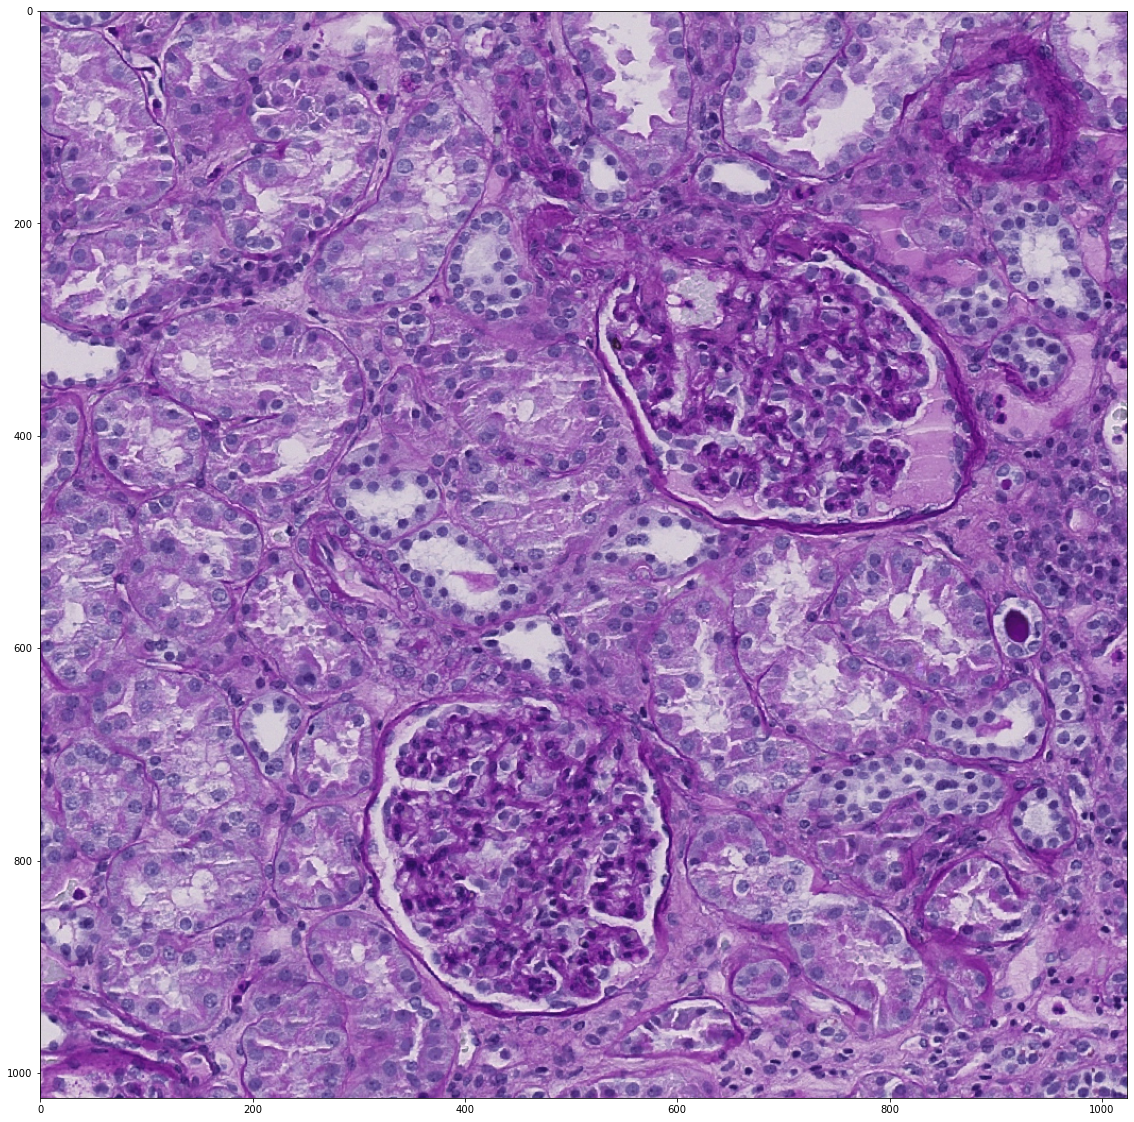

In [18]:
with rasterio.open('/home/jupyter/data/train/2f6ecfcdf.tiff') as raster:
    img = raster.read([1,2,3], window=Window.from_slices((3909, 4933),(11464,12488)))
    img = np.moveaxis(img, 0, -1)
    print(img.shape)
    crs = raster.crs

plt.figure(figsize = (20,20))
plt.imshow(img)
plt.show()


Writing to /home/jupyter/ds_cache/image_0


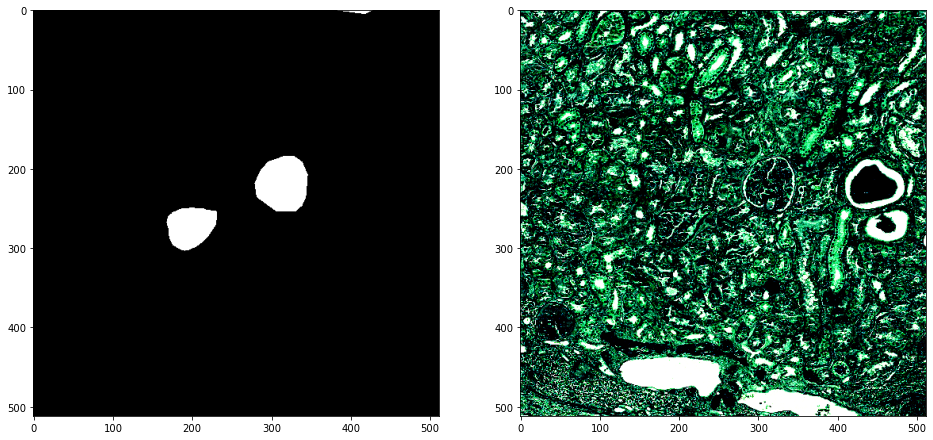

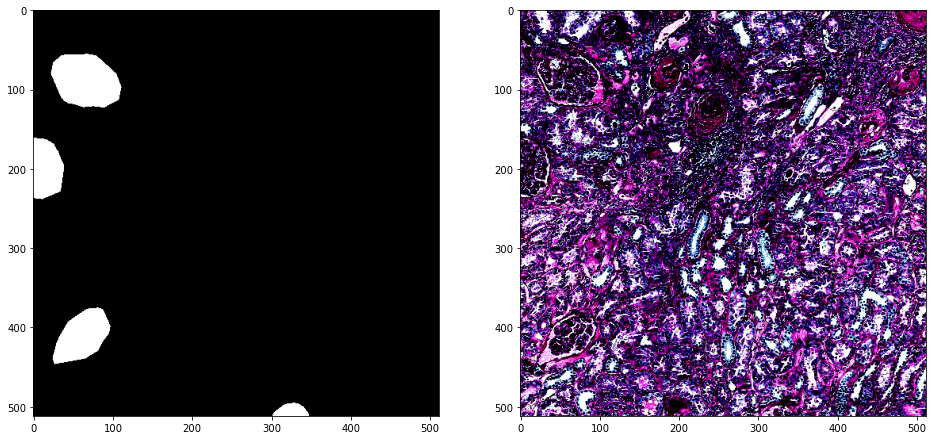

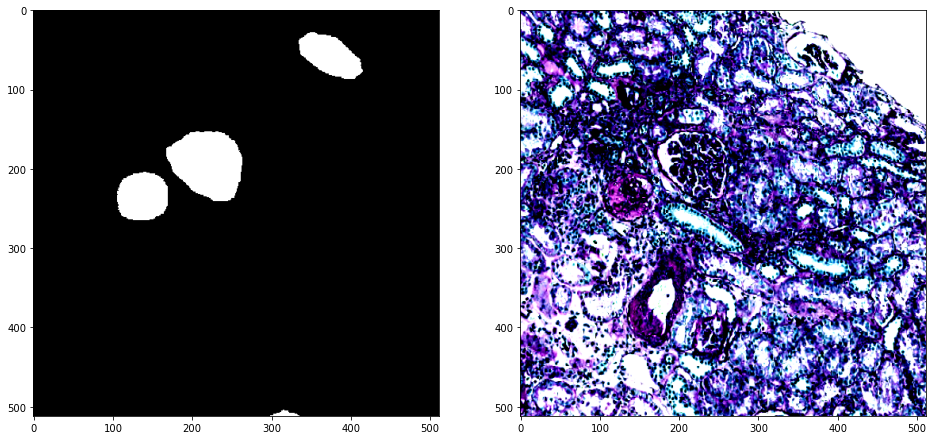

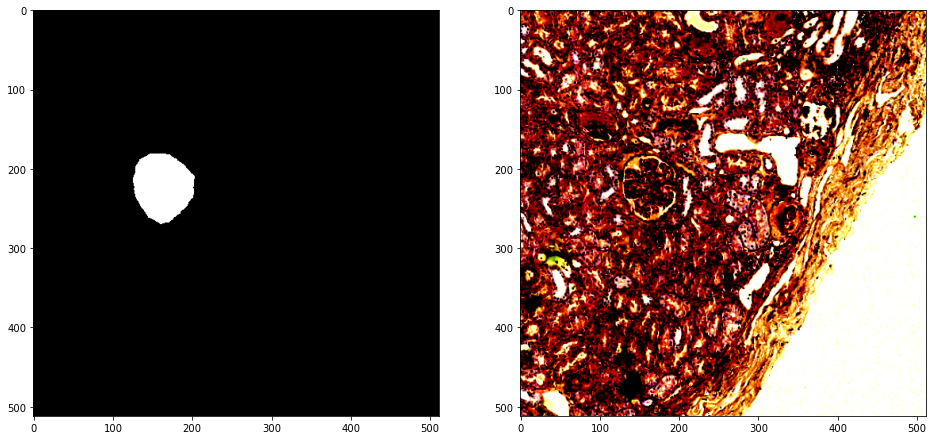

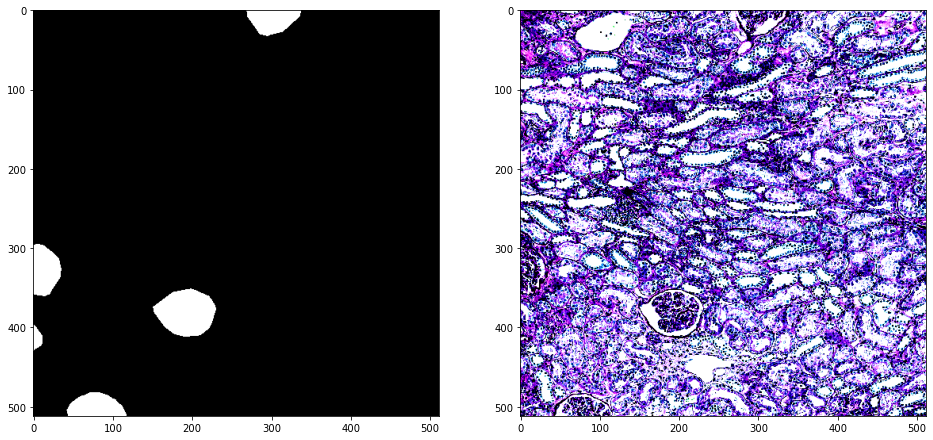

In [19]:
def display_mask_img(idx):
    image, mask = ds[idx]
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(mask[0], cmap='gray')
    plt.subplot(122)
    plt.imshow(np.moveaxis(image.numpy(), 0, -1));

display_mask_img(2)
display_mask_img(1)
display_mask_img(0)
display_mask_img(3)
display_mask_img(5)

In [20]:
image, mask = ds[0]

_ = rle_numba_encode(mask[0]) # compile function with numba

#### Split

In [21]:
def create_split_on_index(img_index = 7):
    valid_idx, train_idx = [], []
    for i in range(len(ds)):
        if ds.slices[i][0] == img_index:
            valid_idx.append(i)
        else:
            train_idx.append(i)
    return valid_idx, train_idx

#### Data loaders

In [22]:
BATCH_SIZE = 16
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
def generate_train_valid_dls(ds, train_idx, valid_idx):
    train_ds = D.Subset(ds, train_idx)
    valid_ds = D.Subset(ds, valid_idx)

    # define training and validation data loaders
    train_dl = D.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    valid_dl = D.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    return train_dl, valid_dl

### Model

In [24]:
ENCODER_NAME = 'se_resnext50_32x4d'

class HuBMAPModel(nn.Module):
    def __init__(self):
        super(HuBMAPModel, self).__init__()
        self.model = Unet(encoder_name = ENCODER_NAME, 
                          encoder_weights = 'imagenet',
                          classes = 1,
                          activation = None)
        
        
    def forward(self, images):
        img_masks = self.model(images)
        return img_masks

In [25]:
def get_model():
    model = HuBMAPModel()
    return model

### Training

In [26]:
LR = 1e-3
WD = 1e-3
BEST_MODEL = 'best_model_unet_512_resnext.pth'

In [27]:
def create_optimizer_scheduler(model, train_dl, epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                    steps_per_epoch=len(train_dl), epochs=epochs)
    return optimizer, scheduler

### Loss

In [28]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.5 * bce + 0.5 * dice

In [29]:
dice_loss = smp.utils.losses.DiceLoss()

def loss_fn(y_pred, y_true):
    return dice_loss(y_pred.sigmoid(), y_true)

In [30]:
def dice_metric(y_pred, y, epsilon = 1.0):
    dims=(-2,-1)
    x = (y_pred > 0).float()
    dc = (2 * (x * y).sum(dims) + epsilon) / ((x + y).sum(dims) + epsilon)
    return dc.mean()

In [31]:
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

In [32]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_epoch(model, dataloader, optim, criterion, scheduler, device="cpu"):
    model.train()
    
    train_loss = []
    labels = []
    outs = []
    lrs = []
    
    tbar = tqdm(dataloader)
    scaler = torch.cuda.amp.GradScaler() # mixed precision support
    for step, (image, target) in enumerate(tbar):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        
        optim.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(image)
            loss = criterion(output, target)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        scaler.step(optim)
        scale = scaler.get_scale()
        scaler.update()
        skip_lr_sched = (scale != scaler.get_scale())
        if not skip_lr_sched:
            scheduler.step()
        
        train_loss.append(loss.item())
        lrs.append(get_lr(optim))
        
        tbar.set_description('loss - {:.4f}'.format(loss))
        
    print(f'Train loss: {np.array(train_loss).mean()}')
    return train_loss, lrs

In [33]:
def val_epoch(model, dataloader, criterion, epoch, device="cpu"):
    model.eval()

    valid_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []
    dice_metrics = []
    iou_metrics = []

    for item in dataloader:
        image, target = item
        image, target = image.to(DEVICE), target.float().to(DEVICE)

        with torch.no_grad():
            output = model(image)
            loss = criterion(output, target)
            dice_metrics.append(dice_metric(output, target))
            iou_metrics.append(iou_metric(output, target))
        valid_loss.append(loss.item())

    avg_loss = np.array(valid_loss).mean()
    print(f'Epoch {epoch} - valid loss: {avg_loss}')
    dice_metrics = [x.item() for x in dice_metrics]
    iou_metrics = [x.item() for x in iou_metrics]
    dice_metric_mean = np.array(dice_metrics).mean()
    iou_metric_mean = np.array(iou_metrics).mean()
    return dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean

In [34]:
def train(epochs, train_dl, valid_dl, optimizer, scheduler):
    best_loss = 100.0
    best_metric = 0
    train_losses = []
    valid_losses = []
    accumulated_lrs = []
    accumulated_dice_metrics = []

    for epoch in tqdm(range(epochs)):
        train_loss, lrs = train_epoch(model, train_dl, optimizer, loss_fn, scheduler, DEVICE)
        dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean = val_epoch(model, valid_dl, loss_fn, epoch, DEVICE)
        train_losses += train_loss
        valid_losses.append(np.array(valid_loss).mean())
        accumulated_lrs += lrs
        accumulated_dice_metrics.append(np.array(dice_metrics).mean())
        if best_metric < iou_metric_mean:
            best_metric = iou_metric_mean
            print('Saving model')
            torch.save(model.state_dict(), BEST_MODEL)
        if best_loss > avg_loss:
            best_loss = avg_loss
        print(f'Epoch {epoch} - val best loss {best_loss} dice metric ({dice_metric_mean}) iou metric ({iou_metric_mean}).')
        
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [35]:
# reset_mask_path()
# !mkdir {MASK_PATH}

In [36]:
EPOCHS = 20

In [37]:
def train_split(split):
    global model
    model = get_model()
    model.to(DEVICE)
    valid_idx, train_idx = create_split_on_index(split)
    f'Proportions valid / train: {len(valid_idx) / len(train_idx)}'
    train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
    optimizer, scheduler = create_optimizer_scheduler(model, train_dl, EPOCHS)
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train(EPOCHS, train_dl, valid_dl, optimizer, scheduler)
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [38]:
def train_split_and_move(split):
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train_split(split)
    stats_df = pd.DataFrame({'train_losses': train_losses, 'accumulated_lrs': accumulated_lrs})
    stats_df[['train_losses']].plot()
    val_stats_df = pd.DataFrame({'valid_losses': valid_losses})
    val_stats_df[['valid_losses']].plot()
    !mv {BEST_MODEL} {split}_{BEST_MODEL}

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Writing to /home/jupyter/ds_cache/image_300
Writing to /home/jupyter/ds_cache/image_100
Writing to /home/jupyter/ds_cache/image_200
Writing to /home/jupyter/ds_cache/image_500
Writing to /home/jupyter/ds_cache/image_400
Train loss: 0.8754755532419359
Writing to /home/jupyter/ds_cache/image_600
Epoch 0 - valid loss: 0.877950131893158
Saving model
Epoch 0 - val best loss 0.877950131893158 dice metric (0.10879488608666829) iou metric (0.07199365592428617).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.8120772355311626
Epoch 1 - valid loss: 0.8029177955218724
Saving model
Epoch 1 - val best loss 0.8029177955218724 dice metric (0.3063775599002838) iou metric (0.25984086309160503).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.7144738000792425
Epoch 2 - valid loss: 0.6299610393387931
Saving model
Epoch 2 - val best loss 0.6299610393387931 dice metric (0.6124899770532336) iou metric (0.5544617176055908).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.4837922067255587
Epoch 3 - valid loss: 0.38942956924438477
Saving model
Epoch 3 - val best loss 0.38942956924438477 dice metric (0.7281297360147748) iou metric (0.6983621886798314).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.2367992868294587
Epoch 4 - valid loss: 0.22721330608640397
Epoch 4 - val best loss 0.22721330608640397 dice metric (0.7234208413532802) iou metric (0.6971338306154523).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.15673687973537961
Epoch 5 - valid loss: 0.17188318286623275
Saving model
Epoch 5 - val best loss 0.17188318286623275 dice metric (0.7633914777210781) iou metric (0.7330871565001351).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.13745334019532074
Epoch 6 - valid loss: 0.1575151171003069
Saving model
Epoch 6 - val best loss 0.1575151171003069 dice metric (0.7773501362119403) iou metric (0.7411311779703412).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.12794189839749723
Epoch 7 - valid loss: 0.17775975806372507
Epoch 7 - val best loss 0.1575151171003069 dice metric (0.7045848880495343) iou metric (0.7058480296816144).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.1281409118626569
Epoch 8 - valid loss: 0.12822284868785314
Saving model
Epoch 8 - val best loss 0.12822284868785314 dice metric (0.7480265753609794) iou metric (0.7781211818967547).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.1187764132345045
Epoch 9 - valid loss: 0.12555149623325892
Saving model
Epoch 9 - val best loss 0.12555149623325892 dice metric (0.7703248688152858) iou metric (0.7826405678476606).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.11285319682714101
Epoch 10 - valid loss: 0.10907248088291713
Saving model
Epoch 10 - val best loss 0.10907248088291713 dice metric (0.8095595410891941) iou metric (0.8078323262078422).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.1138714116972846
Epoch 11 - valid loss: 0.1183198264666966
Epoch 11 - val best loss 0.10907248088291713 dice metric (0.8248352408409119) iou metric (0.7920129810060773).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.11293603117401535
Epoch 12 - valid loss: 0.12407948289598737
Epoch 12 - val best loss 0.10907248088291713 dice metric (0.8015151194163731) iou metric (0.7824307339532035).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.1080865908313442
Epoch 13 - valid loss: 0.12358583722795759
Epoch 13 - val best loss 0.10907248088291713 dice metric (0.7770583629608154) iou metric (0.7826067634991237).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.1046925831485439
Epoch 14 - valid loss: 0.10672599077224731
Saving model
Epoch 14 - val best loss 0.10672599077224731 dice metric (0.806193505014692) iou metric (0.8098031963620868).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.10364041940585987
Epoch 15 - valid loss: 0.11417794227600098
Epoch 15 - val best loss 0.10672599077224731 dice metric (0.8374622804777963) iou metric (0.7977309141840253).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.10061608295182924
Epoch 16 - valid loss: 0.10121447699410575
Saving model
Epoch 16 - val best loss 0.10121447699410575 dice metric (0.8241912211690631) iou metric (0.818225017615727).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.09753714542131166
Epoch 17 - valid loss: 0.10104114668709892
Saving model
Epoch 17 - val best loss 0.10104114668709892 dice metric (0.8243185537202018) iou metric (0.8188689947128296).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.09894676627339544
Epoch 18 - valid loss: 0.10843956470489502
Epoch 18 - val best loss 0.10104114668709892 dice metric (0.8215250628335136) iou metric (0.8066831912313189).


  0%|          | 0/37 [00:00<?, ?it/s]

Train loss: 0.09978744951454369
Epoch 19 - valid loss: 0.11735441855021886
Epoch 19 - val best loss 0.10104114668709892 dice metric (0.8063492434365409) iou metric (0.792856650693076).


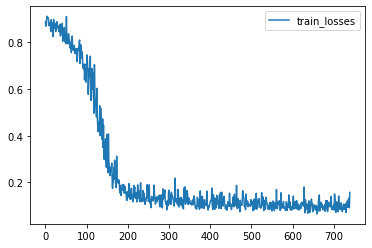

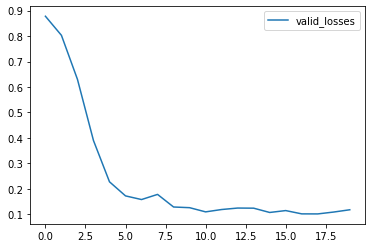

In [39]:
train_split_and_move(7)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.8970458894968033
Epoch 0 - valid loss: 0.887008011341095
Saving model
Epoch 0 - val best loss 0.887008011341095 dice metric (0.14159353449940681) iou metric (0.10432017408311367).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.7769090071320534
Epoch 1 - valid loss: 0.7835076004266739
Saving model
Epoch 1 - val best loss 0.7835076004266739 dice metric (0.40661951899528503) iou metric (0.3198728710412979).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.5973248809576035
Epoch 2 - valid loss: 0.5586823672056198
Saving model
Epoch 2 - val best loss 0.5586823672056198 dice metric (0.7304760366678238) iou metric (0.6333574503660202).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.34246078282594683
Epoch 3 - valid loss: 0.2740232050418854
Saving model
Epoch 3 - val best loss 0.2740232050418854 dice metric (0.8276560455560684) iou metric (0.7519341856241226).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.18606218248605727
Epoch 4 - valid loss: 0.15213993191719055
Saving model
Epoch 4 - val best loss 0.15213993191719055 dice metric (0.8648907095193863) iou metric (0.7972321808338165).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.14898354411125184
Epoch 5 - valid loss: 0.16930744051933289
Epoch 5 - val best loss 0.15213993191719055 dice metric (0.8298989981412888) iou metric (0.7303081303834915).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.13153613358736038
Epoch 6 - valid loss: 0.11217845976352692
Saving model
Epoch 6 - val best loss 0.11217845976352692 dice metric (0.8646449744701385) iou metric (0.8098742812871933).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.12239465117454529
Epoch 7 - valid loss: 0.16708463430404663
Epoch 7 - val best loss 0.11217845976352692 dice metric (0.7817836105823517) iou metric (0.7234966307878494).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.12601599842309952
Epoch 8 - valid loss: 0.11148960888385773
Epoch 8 - val best loss 0.11148960888385773 dice metric (0.8782264888286591) iou metric (0.8063871711492538).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.12008895725011826
Epoch 9 - valid loss: 0.10393790900707245
Saving model
Epoch 9 - val best loss 0.10393790900707245 dice metric (0.8665895164012909) iou metric (0.8141775280237198).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.11761571615934371
Epoch 10 - valid loss: 0.10891881585121155
Epoch 10 - val best loss 0.10393790900707245 dice metric (0.856431782245636) iou metric (0.8078139573335648).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.11356255561113357
Epoch 11 - valid loss: 0.104326993227005
Epoch 11 - val best loss 0.10393790900707245 dice metric (0.8461928516626358) iou metric (0.8131423592567444).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.11266309469938278
Epoch 12 - valid loss: 0.10344547033309937
Saving model
Epoch 12 - val best loss 0.10344547033309937 dice metric (0.8140950351953506) iou metric (0.8145616799592972).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.1043108120560646
Epoch 13 - valid loss: 0.10873524844646454
Epoch 13 - val best loss 0.10344547033309937 dice metric (0.8621687740087509) iou metric (0.8067500591278076).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.10646318197250366
Epoch 14 - valid loss: 0.08748219907283783
Saving model
Epoch 14 - val best loss 0.08748219907283783 dice metric (0.9009169638156891) iou metric (0.8414146304130554).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.10207944512367248
Epoch 15 - valid loss: 0.08440490067005157
Saving model
Epoch 15 - val best loss 0.08440490067005157 dice metric (0.8703877627849579) iou metric (0.845675989985466).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.10049124658107758
Epoch 16 - valid loss: 0.09146517515182495
Epoch 16 - val best loss 0.08440490067005157 dice metric (0.8897930830717087) iou metric (0.8344701826572418).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.10087200701236725
Epoch 17 - valid loss: 0.08584199845790863
Epoch 17 - val best loss 0.08440490067005157 dice metric (0.8877743780612946) iou metric (0.8437991440296173).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.09834787994623184
Epoch 18 - valid loss: 0.09149600565433502
Epoch 18 - val best loss 0.08440490067005157 dice metric (0.8858101665973663) iou metric (0.8349235653877258).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.09943775981664657
Epoch 19 - valid loss: 0.08490043878555298
Epoch 19 - val best loss 0.08440490067005157 dice metric (0.8874163031578064) iou metric (0.8447511047124863).


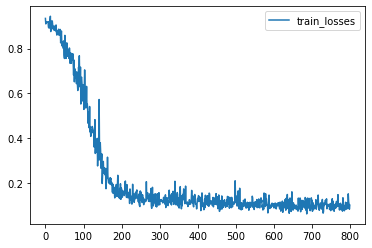

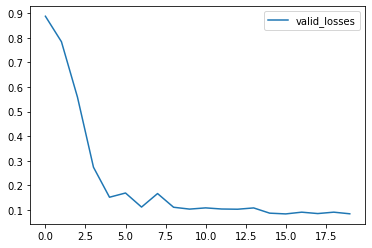

In [40]:
train_split_and_move(0)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.8905511076857404
Epoch 0 - valid loss: 0.9186847805976868
Saving model
Epoch 0 - val best loss 0.9186847805976868 dice metric (0.07779387384653091) iou metric (0.05226908251643181).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.8443398184892608
Epoch 1 - valid loss: 0.8876505096753439
Saving model
Epoch 1 - val best loss 0.8876505096753439 dice metric (0.12122369557619095) iou metric (0.11091214170058568).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.7799270196658808
Epoch 2 - valid loss: 0.805180033047994
Saving model
Epoch 2 - val best loss 0.805180033047994 dice metric (0.5349017282327017) iou metric (0.4518968065579732).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.6137973448125328
Epoch 3 - valid loss: 0.648357629776001
Saving model
Epoch 3 - val best loss 0.648357629776001 dice metric (0.5593037009239197) iou metric (0.5286669631799062).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.34349982040684396
Epoch 4 - valid loss: 0.3369021415710449
Saving model
Epoch 4 - val best loss 0.3369021415710449 dice metric (0.6818966865539551) iou metric (0.6421403090159098).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.17257811238126056
Epoch 5 - valid loss: 0.28508474429448444
Epoch 5 - val best loss 0.28508474429448444 dice metric (0.5797848502794901) iou metric (0.5966876546541849).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.14037012617762495
Epoch 6 - valid loss: 0.34363581736882526
Epoch 6 - val best loss 0.28508474429448444 dice metric (0.5494621594746908) iou metric (0.5134829183419546).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.13569891452789307
Epoch 7 - valid loss: 0.2505068778991699
Epoch 7 - val best loss 0.2505068778991699 dice metric (0.5984608133633932) iou metric (0.6117733518282572).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.12559455633163452
Epoch 8 - valid loss: 0.20277762413024902
Saving model
Epoch 8 - val best loss 0.20277762413024902 dice metric (0.6931075851122538) iou metric (0.6698347131411234).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.11918443005259444
Epoch 9 - valid loss: 0.19054388999938965
Saving model
Epoch 9 - val best loss 0.19054388999938965 dice metric (0.7908663749694824) iou metric (0.6854268312454224).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1175422406778103
Epoch 10 - valid loss: 0.25088202953338623
Epoch 10 - val best loss 0.19054388999938965 dice metric (0.7357403039932251) iou metric (0.6148510277271271).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.1176572776422268
Epoch 11 - valid loss: 0.17523741722106934
Saving model
Epoch 11 - val best loss 0.17523741722106934 dice metric (0.6647215286890665) iou metric (0.7090810537338257).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.11381628891316856
Epoch 12 - valid loss: 0.17395625511805216
Epoch 12 - val best loss 0.17395625511805216 dice metric (0.7949009339014689) iou metric (0.7088093956311544).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.10588099607607214
Epoch 13 - valid loss: 0.16243825356165567
Saving model
Epoch 13 - val best loss 0.16243825356165567 dice metric (0.8005164861679077) iou metric (0.7251209417978922).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.10455823235395478
Epoch 14 - valid loss: 0.17889857292175293
Epoch 14 - val best loss 0.16243825356165567 dice metric (0.7922462026278178) iou metric (0.7008001804351807).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.10214974967444815
Epoch 15 - valid loss: 0.16786950826644897
Epoch 15 - val best loss 0.16243825356165567 dice metric (0.7438756823539734) iou metric (0.7157668471336365).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.10170386041082986
Epoch 16 - valid loss: 0.17123846213022867
Epoch 16 - val best loss 0.16243825356165567 dice metric (0.8219126661618551) iou metric (0.7116986314455668).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.09971720561748598
Epoch 17 - valid loss: 0.18463043371836343
Epoch 17 - val best loss 0.16243825356165567 dice metric (0.7180732488632202) iou metric (0.6919932166735331).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.09710270602528642
Epoch 18 - valid loss: 0.14013075828552246
Saving model
Epoch 18 - val best loss 0.14013075828552246 dice metric (0.8580520749092102) iou metric (0.7564096450805664).


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss: 0.09846014947426028
Epoch 19 - valid loss: 0.20923725763956705
Epoch 19 - val best loss 0.14013075828552246 dice metric (0.6847824255625407) iou metric (0.6634991566340128).


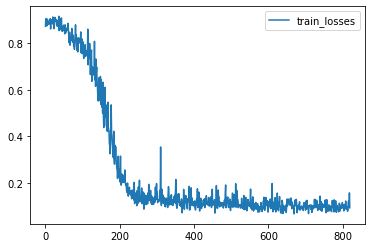

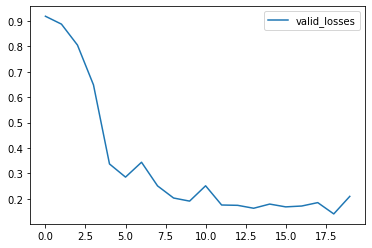

In [44]:
train_split_and_move(1)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.8967813402414322
Epoch 0 - valid loss: 0.8841361328959465
Saving model
Epoch 0 - val best loss 0.8841361328959465 dice metric (0.10029980447143316) iou metric (0.06274733133614063).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.8586026645369
Epoch 1 - valid loss: 0.8351926356554031
Saving model
Epoch 1 - val best loss 0.8351926356554031 dice metric (0.16264022048562765) iou metric (0.18914875481277704).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.7974958668152491
Epoch 2 - valid loss: 0.7703219726681709
Saving model
Epoch 2 - val best loss 0.7703219726681709 dice metric (0.6208846792578697) iou metric (0.6243755295872688).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.6767307486799028
Epoch 3 - valid loss: 0.5769428834319115
Saving model
Epoch 3 - val best loss 0.5769428834319115 dice metric (0.7494932636618614) iou metric (0.7488439157605171).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.452164759238561
Epoch 4 - valid loss: 0.3548077866435051
Epoch 4 - val best loss 0.3548077866435051 dice metric (0.7302379906177521) iou metric (0.7062467858195305).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.24902070065339407
Epoch 5 - valid loss: 0.2275952771306038
Epoch 5 - val best loss 0.2275952771306038 dice metric (0.78237284719944) iou metric (0.7310563400387764).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.18164613677395713
Epoch 6 - valid loss: 0.11992020905017853
Saving model
Epoch 6 - val best loss 0.11992020905017853 dice metric (0.825259804725647) iou metric (0.8202156126499176).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.1476394534111023
Epoch 7 - valid loss: 0.1131126657128334
Saving model
Epoch 7 - val best loss 0.1131126657128334 dice metric (0.8475755527615547) iou metric (0.8205595016479492).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.14132457309299046
Epoch 8 - valid loss: 0.10771936178207397
Saving model
Epoch 8 - val best loss 0.10771936178207397 dice metric (0.8105489984154701) iou metric (0.821505218744278).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.14026842349105412
Epoch 9 - valid loss: 0.08693090081214905
Saving model
Epoch 9 - val best loss 0.08693090081214905 dice metric (0.8721268251538277) iou metric (0.8495110720396042).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.12839980920155844
Epoch 10 - valid loss: 0.09595634043216705
Epoch 10 - val best loss 0.08693090081214905 dice metric (0.8320134878158569) iou metric (0.835212342441082).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.12722228467464447
Epoch 11 - valid loss: 0.08695940673351288
Epoch 11 - val best loss 0.08693090081214905 dice metric (0.8742892071604729) iou metric (0.8464574590325356).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.12144733965396881
Epoch 12 - valid loss: 0.08307603746652603
Saving model
Epoch 12 - val best loss 0.08307603746652603 dice metric (0.8754830956459045) iou metric (0.8534535393118858).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.11516155468093024
Epoch 13 - valid loss: 0.0792391449213028
Saving model
Epoch 13 - val best loss 0.0792391449213028 dice metric (0.851578876376152) iou metric (0.8584583103656769).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.1135526481601927
Epoch 14 - valid loss: 0.08587469905614853
Epoch 14 - val best loss 0.0792391449213028 dice metric (0.8560186475515366) iou metric (0.8477263525128365).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.1144468602206972
Epoch 15 - valid loss: 0.08272692561149597
Epoch 15 - val best loss 0.0792391449213028 dice metric (0.8377712741494179) iou metric (0.8515823483467102).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.1110026025109821
Epoch 16 - valid loss: 0.07899010181427002
Epoch 16 - val best loss 0.07899010181427002 dice metric (0.8603665307164192) iou metric (0.8584077954292297).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.10784374011887445
Epoch 17 - valid loss: 0.0782240480184555
Saving model
Epoch 17 - val best loss 0.0782240480184555 dice metric (0.8688481152057648) iou metric (0.8597206920385361).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.10645353297392528
Epoch 18 - valid loss: 0.08235333114862442
Epoch 18 - val best loss 0.0782240480184555 dice metric (0.8671230971813202) iou metric (0.8529409244656563).


  0%|          | 0/36 [00:00<?, ?it/s]

Train loss: 0.10530530247423384
Epoch 19 - valid loss: 0.07534409314393997
Saving model
Epoch 19 - val best loss 0.07534409314393997 dice metric (0.8489353358745575) iou metric (0.8648489415645599).


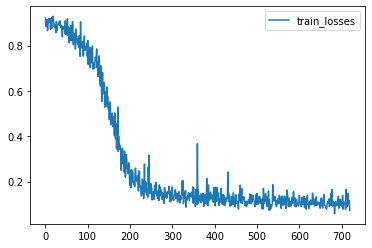

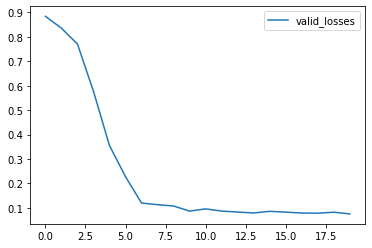

In [45]:
train_split_and_move(2)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.8921110332012177
Epoch 0 - valid loss: 0.8777650147676468
Saving model
Epoch 0 - val best loss 0.8777650147676468 dice metric (0.11632602661848068) iou metric (0.07494225911796093).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.8483907535672188
Epoch 1 - valid loss: 0.8407357931137085
Saving model
Epoch 1 - val best loss 0.8407357931137085 dice metric (0.20896290615200996) iou metric (0.24115726724267006).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.785020524263382
Epoch 2 - valid loss: 0.7588230818510056
Saving model
Epoch 2 - val best loss 0.7588230818510056 dice metric (0.7275447100400925) iou metric (0.6838023811578751).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.6249340459704399
Epoch 3 - valid loss: 0.5489914119243622
Saving model
Epoch 3 - val best loss 0.5489914119243622 dice metric (0.8081927299499512) iou metric (0.7712647765874863).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.35372726172208785
Epoch 4 - valid loss: 0.23758326470851898
Saving model
Epoch 4 - val best loss 0.23758326470851898 dice metric (0.8578315526247025) iou metric (0.7805479466915131).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.1935214415192604
Epoch 5 - valid loss: 0.1714661717414856
Epoch 5 - val best loss 0.1714661717414856 dice metric (0.7936950623989105) iou metric (0.7611556202173233).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.1556788668036461
Epoch 6 - valid loss: 0.10781805217266083
Saving model
Epoch 6 - val best loss 0.10781805217266083 dice metric (0.8846655786037445) iou metric (0.8318237513303757).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.13280526250600816
Epoch 7 - valid loss: 0.08295077085494995
Saving model
Epoch 7 - val best loss 0.08295077085494995 dice metric (0.8861502856016159) iou metric (0.8637858182191849).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.12956087291240692
Epoch 8 - valid loss: 0.0875682383775711
Epoch 8 - val best loss 0.08295077085494995 dice metric (0.8772450238466263) iou metric (0.8478156477212906).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.12380786538124085
Epoch 9 - valid loss: 0.07852594554424286
Epoch 9 - val best loss 0.07852594554424286 dice metric (0.8824565261602402) iou metric (0.8602874130010605).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.12037039697170257
Epoch 10 - valid loss: 0.08644136786460876
Epoch 10 - val best loss 0.07852594554424286 dice metric (0.896056279540062) iou metric (0.8468156009912491).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.11748297214508056
Epoch 11 - valid loss: 0.07858909666538239
Epoch 11 - val best loss 0.07852594554424286 dice metric (0.8578789085149765) iou metric (0.8595390319824219).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.11087014228105545
Epoch 12 - valid loss: 0.08109429478645325
Epoch 12 - val best loss 0.07852594554424286 dice metric (0.8870990723371506) iou metric (0.8540818393230438).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.11318332701921463
Epoch 13 - valid loss: 0.07554544508457184
Epoch 13 - val best loss 0.07554544508457184 dice metric (0.8926455080509186) iou metric (0.8621585965156555).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.10736842751502991
Epoch 14 - valid loss: 0.07380783557891846
Saving model
Epoch 14 - val best loss 0.07380783557891846 dice metric (0.9090588688850403) iou metric (0.8657420426607132).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.10504446774721146
Epoch 15 - valid loss: 0.06726391613483429
Saving model
Epoch 15 - val best loss 0.06726391613483429 dice metric (0.9106566160917282) iou metric (0.8767454326152802).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.1033786565065384
Epoch 16 - valid loss: 0.07520383596420288
Epoch 16 - val best loss 0.06726391613483429 dice metric (0.8925505876541138) iou metric (0.8631319552659988).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.10257040709257126
Epoch 17 - valid loss: 0.06886088848114014
Epoch 17 - val best loss 0.06726391613483429 dice metric (0.9217649549245834) iou metric (0.873989149928093).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.10563549101352691
Epoch 18 - valid loss: 0.07002192735671997
Epoch 18 - val best loss 0.06726391613483429 dice metric (0.8887090533971786) iou metric (0.8722897917032242).


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: 0.10177488923072815
Epoch 19 - valid loss: 0.06750994920730591
Epoch 19 - val best loss 0.06726391613483429 dice metric (0.9140093773603439) iou metric (0.8765217512845993).


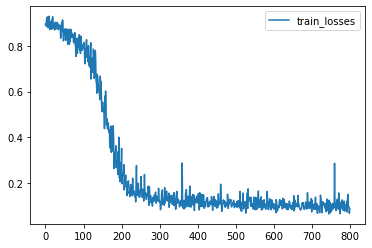

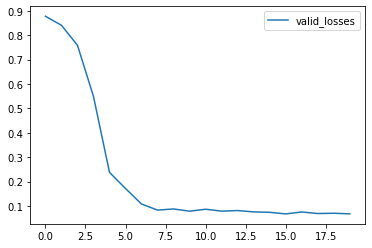

In [42]:
train_split_and_move(3)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.8824972620135859
Epoch 0 - valid loss: 0.8387680947780609
Saving model
Epoch 0 - val best loss 0.8387680947780609 dice metric (0.16948395470778146) iou metric (0.12823757405082384).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.7862041467114499
Epoch 1 - valid loss: 0.7311451633771261
Saving model
Epoch 1 - val best loss 0.7311451633771261 dice metric (0.4215477854013443) iou metric (0.34309449791908264).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.6497112826297158
Epoch 2 - valid loss: 0.5320597092310587
Saving model
Epoch 2 - val best loss 0.5320597092310587 dice metric (0.7026222745577494) iou metric (0.6404253443082174).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.37629378783075434
Epoch 3 - valid loss: 0.277127077182134
Saving model
Epoch 3 - val best loss 0.277127077182134 dice metric (0.7682217359542847) iou metric (0.725384404261907).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.198822126576775
Epoch 4 - valid loss: 0.18605453769365946
Saving model
Epoch 4 - val best loss 0.18605453769365946 dice metric (0.766310473283132) iou metric (0.7305796345074972).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.14337701546518425
Epoch 5 - valid loss: 0.1823855141798655
Epoch 5 - val best loss 0.1823855141798655 dice metric (0.7523897190888723) iou metric (0.7093787093957266).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.1327300212885204
Epoch 6 - valid loss: 0.1681110362211863
Epoch 6 - val best loss 0.1681110362211863 dice metric (0.767563670873642) iou metric (0.722944180170695).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.12093826500993025
Epoch 7 - valid loss: 0.17941262324651083
Epoch 7 - val best loss 0.1681110362211863 dice metric (0.7041878004868826) iou metric (0.7026268243789673).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.12748042846980848
Epoch 8 - valid loss: 0.17112629612286887
Epoch 8 - val best loss 0.1681110362211863 dice metric (0.7487613260746002) iou metric (0.7172870685656866).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.11132686389120001
Epoch 9 - valid loss: 0.171986053387324
Epoch 9 - val best loss 0.1681110362211863 dice metric (0.77961998184522) iou metric (0.7135680317878723).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.11100399337316814
Epoch 10 - valid loss: 0.15864049394925436
Saving model
Epoch 10 - val best loss 0.15864049394925436 dice metric (0.7952360510826111) iou metric (0.7348098754882812).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.1090926888741945
Epoch 11 - valid loss: 0.15852882464726767
Epoch 11 - val best loss 0.15852882464726767 dice metric (0.7720981339613596) iou metric (0.7312914629777273).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.1071467587822362
Epoch 12 - valid loss: 0.1495455006758372
Saving model
Epoch 12 - val best loss 0.1495455006758372 dice metric (0.7711207022269567) iou metric (0.7434194684028625).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.10200419237739161
Epoch 13 - valid loss: 0.14313356081644693
Saving model
Epoch 13 - val best loss 0.14313356081644693 dice metric (0.8103369772434235) iou metric (0.7519779105981191).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.10451698616931313
Epoch 14 - valid loss: 0.15030633409818014
Epoch 14 - val best loss 0.14313356081644693 dice metric (0.7672973175843557) iou metric (0.7429750462373098).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.10181491155373423
Epoch 15 - valid loss: 0.14119245608647665
Saving model
Epoch 15 - val best loss 0.14119245608647665 dice metric (0.8021958569685618) iou metric (0.7550924022992452).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.09758216299508747
Epoch 16 - valid loss: 0.15080934762954712
Epoch 16 - val best loss 0.14119245608647665 dice metric (0.7582051654656728) iou metric (0.7422787050406138).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.09915015728850114
Epoch 17 - valid loss: 0.14750990271568298
Epoch 17 - val best loss 0.14119245608647665 dice metric (0.7970474561055502) iou metric (0.7450220783551534).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.09359320527628849
Epoch 18 - valid loss: 0.16438033183415732
Epoch 18 - val best loss 0.14119245608647665 dice metric (0.7604710062344869) iou metric (0.7257671107848486).


  0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 0.09684835766491137
Epoch 19 - valid loss: 0.14182031154632568
Epoch 19 - val best loss 0.14119245608647665 dice metric (0.80093385775884) iou metric (0.7545507748921713).


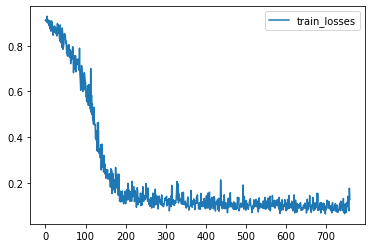

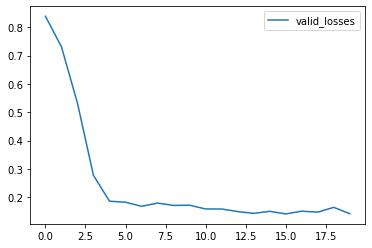

In [43]:
train_split_and_move(4)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.8868817506414471
Epoch 0 - valid loss: 0.8553922772407532
Saving model
Epoch 0 - val best loss 0.8553922772407532 dice metric (0.13133242055773736) iou metric (0.09063910618424416).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.7967089125604341
Epoch 1 - valid loss: 0.7723494827747345
Saving model
Epoch 1 - val best loss 0.7723494827747345 dice metric (0.35888563096523285) iou metric (0.30793639123439787).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.662510765321327
Epoch 2 - valid loss: 0.5350260257720947
Saving model
Epoch 2 - val best loss 0.5350260257720947 dice metric (0.6759094595909119) iou metric (0.6489579081535339).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.3966220635356325
Epoch 3 - valid loss: 0.315321284532547
Saving model
Epoch 3 - val best loss 0.315321284532547 dice metric (0.7619859933853149) iou metric (0.704825496673584).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.19491351373267896
Epoch 4 - valid loss: 0.21641913652420045
Epoch 4 - val best loss 0.21641913652420045 dice metric (0.7327420681715011) iou metric (0.6823459088802337).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.14540141640287457
Epoch 5 - valid loss: 0.21201157569885254
Epoch 5 - val best loss 0.21201157569885254 dice metric (0.7268291711807251) iou metric (0.6656390607357026).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.12698023788856738
Epoch 6 - valid loss: 0.1573617696762085
Saving model
Epoch 6 - val best loss 0.1573617696762085 dice metric (0.7606528997421265) iou metric (0.7360931754112243).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.11891372095454823
Epoch 7 - valid loss: 0.14609147906303405
Saving model
Epoch 7 - val best loss 0.14609147906303405 dice metric (0.783593374490738) iou metric (0.7509218573570251).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.11645699992324367
Epoch 8 - valid loss: 0.16192094087600709
Epoch 8 - val best loss 0.14609147906303405 dice metric (0.7366371572017669) iou metric (0.7265757381916046).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.114315542307767
Epoch 9 - valid loss: 0.1440141797065735
Saving model
Epoch 9 - val best loss 0.1440141797065735 dice metric (0.7988698005676269) iou metric (0.7518620908260345).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.10975236603707979
Epoch 10 - valid loss: 0.1529698669910431
Epoch 10 - val best loss 0.1440141797065735 dice metric (0.7684526383876801) iou metric (0.7386722087860107).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.10237579815315478
Epoch 11 - valid loss: 0.14233582019805907
Saving model
Epoch 11 - val best loss 0.14233582019805907 dice metric (0.8050012767314911) iou metric (0.7533439815044403).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.10306706031163533
Epoch 12 - valid loss: 0.13932079076766968
Saving model
Epoch 12 - val best loss 0.13932079076766968 dice metric (0.7906522989273072) iou metric (0.757839298248291).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.09764497749733203
Epoch 13 - valid loss: 0.13871085047721862
Saving model
Epoch 13 - val best loss 0.13871085047721862 dice metric (0.7881958603858947) iou metric (0.758855676651001).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.09614447030154141
Epoch 14 - valid loss: 0.13941600322723388
Epoch 14 - val best loss 0.13871085047721862 dice metric (0.7843204319477082) iou metric (0.7572286903858185).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.09263767618121523
Epoch 15 - valid loss: 0.1376972734928131
Saving model
Epoch 15 - val best loss 0.1376972734928131 dice metric (0.7703240215778351) iou metric (0.7596990644931794).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.09444891864603217
Epoch 16 - valid loss: 0.14277661442756653
Epoch 16 - val best loss 0.1376972734928131 dice metric (0.7710059881210327) iou metric (0.7519921660423279).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.08994720018271243
Epoch 17 - valid loss: 0.1381554663181305
Epoch 17 - val best loss 0.1376972734928131 dice metric (0.772316700220108) iou metric (0.7591949224472045).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.0895881454149882
Epoch 18 - valid loss: 0.13672396540641785
Saving model
Epoch 18 - val best loss 0.13672396540641785 dice metric (0.8068763494491578) iou metric (0.7614250779151917).


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.0892835349747629
Epoch 19 - valid loss: 0.13248744010925292
Saving model
Epoch 19 - val best loss 0.13248744010925292 dice metric (0.777878874540329) iou metric (0.768054622411728).


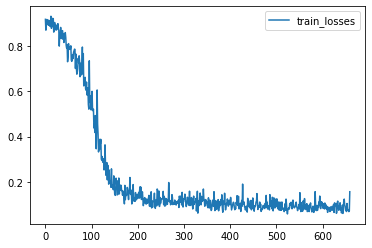

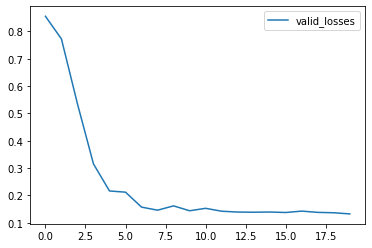

In [48]:
train_split_and_move(5)

In [ ]:
train_split_and_move(6)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.8794491520294776
Epoch 0 - valid loss: 0.8135683536529541
Saving model
Epoch 0 - val best loss 0.8135683536529541 dice metric (0.23968614935874938) iou metric (0.23152795135974885).


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.7846145385350937
Epoch 1 - valid loss: 0.6865687608718872
Saving model
Epoch 1 - val best loss 0.6865687608718872 dice metric (0.5362811625003815) iou metric (0.5160428822040558).


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.6425425074039361
Epoch 2 - valid loss: 0.45102856159210203
Saving model
Epoch 2 - val best loss 0.45102856159210203 dice metric (0.7046064972877503) iou metric (0.7021737217903137).


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.359120018971272
Epoch 3 - valid loss: 0.24183560609817506
Saving model
Epoch 3 - val best loss 0.24183560609817506 dice metric (0.7206529378890991) iou metric (0.7145308971405029).


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.17478031378525954
Epoch 4 - valid loss: 0.1668885350227356
Saving model
Epoch 4 - val best loss 0.1668885350227356 dice metric (0.7418912768363952) iou metric (0.7413684725761414).


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.13790562519660363
Epoch 5 - valid loss: 0.15314825773239135
Saving model
Epoch 5 - val best loss 0.15314825773239135 dice metric (0.7655067920684815) iou metric (0.7477072596549987).


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.1315074318494552
Epoch 6 - valid loss: 0.18981051445007324
Epoch 6 - val best loss 0.15314825773239135 dice metric (0.6658002495765686) iou metric (0.687678873538971).


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.12332793535330357
Epoch 7 - valid loss: 0.17769834995269776
Epoch 7 - val best loss 0.15314825773239135 dice metric (0.7318082690238953) iou metric (0.70391685962677).


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.12669779092837602
Epoch 8 - valid loss: 0.14842811822891236
Epoch 8 - val best loss 0.14842811822891236 dice metric (0.7213774442672729) iou metric (0.7435364484786987).


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.11184696356455485
Epoch 9 - valid loss: 0.13082387447357177
Saving model
Epoch 9 - val best loss 0.13082387447357177 dice metric (0.8087551236152649) iou metric (0.770896577835083).


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.1097226524964357
Epoch 10 - valid loss: 0.15656943321228028
Epoch 10 - val best loss 0.13082387447357177 dice metric (0.7480199456214904) iou metric (0.7345354318618774).


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.10835135747224857
Epoch 11 - valid loss: 0.14656274318695067
Epoch 11 - val best loss 0.13082387447357177 dice metric (0.774683141708374) iou metric (0.7458218455314636).


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.10731567633457673
Epoch 12 - valid loss: 0.13935068845748902
Epoch 12 - val best loss 0.13082387447357177 dice metric (0.7543375372886658) iou metric (0.7584022521972656).


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss: 0.10608654297315158
Epoch 13 - valid loss: 0.14790931940078736
Epoch 13 - val best loss 0.13082387447357177 dice metric (0.74077228307724) iou metric (0.7436995387077332).


  0%|          | 0/39 [00:00<?, ?it/s]

In [44]:
!mv *.pth models